# Extract features from a single slide

## Import

In [8]:
import sys
sys.path.append("./codes/") # Should change to specific
from functions import extractor, utils
import numpy as np
import os
import pandas as pd
import shutil
from tqdm import tqdm
import warnings
import logging
import matplotlib.pyplot as plt

## Parameters

Using liver metastases as an example, we predefined textual labels for different tissue categories and generated a mapping dictionary from numerical labels to their corresponding textual annotations.

In [17]:
tissues = ["BACK","DEB","LIN","LYM","STR","TUM"]
NUM_CLASSES = len(tissues)
label_dict = {i:label for label,i in zip(tissues,range(0,NUM_CLASSES))}
print(label_dict)

{0: 'BACK', 1: 'DEB', 2: 'LIN', 3: 'LYM', 4: 'STR', 5: 'TUM'}


Subsequently, relevant paths are specified. The following parameters should be modified to match your designated paths:
- `csv_path`：This path points to a CSV file that stores the coordinates and category of each patch. In this notebook, the example file is generated from the output of the `TIAToolbox` pipeline.
- `running_folder`: This path refers to a folder used for storing intermediate results during processing.

In [18]:
# 指定路径
csv_path = "./tia_predict.csv"
running_folder = "./running"

In [19]:
df = pd.read_csv(csv_path)
df.head()

,predictions,coordinates,label,pretrained_model,resolution,units
0,0,"[448, 0, 672, 224]",NaN,NaN,1,baseline
1,0,"[672, 0, 896, 224]",NaN,NaN,1,baseline
2,0,"[1344, 0, 1568, 224]",NaN,NaN,1,baseline
3,0,"[6944, 0, 7168, 224]",NaN,NaN,1,baseline
4,0,"[11200, 0, 11424, 224]",NaN,NaN,1,baseline


## Extraction

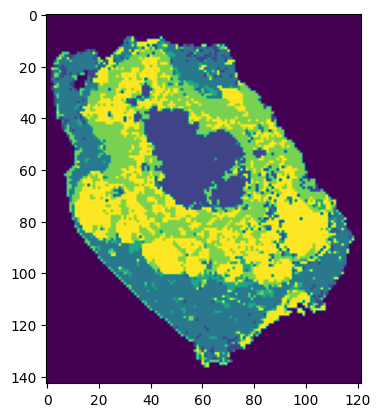

In [31]:
os.makedirs(running_folder,exist_ok=True)

# Initiate
p_extractor = extractor.feature_extractor(
    output_df=csv_path,
    label_dict=label_dict)

# Get predicted matrix
p_extractor.get_matrix()
plt.imshow(p_extractor.pred_matrix)

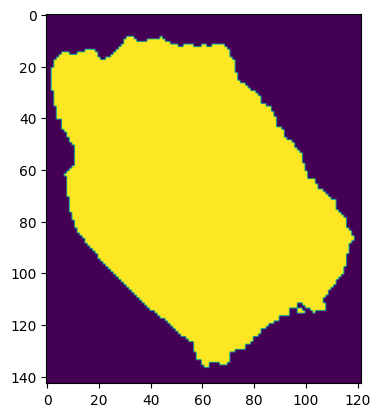

In [32]:
p_extractor.get_tissue_mask()
plt.imshow(p_extractor.tissue_mask)

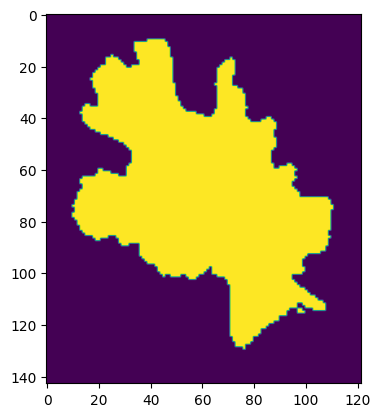

In [33]:
# Tumor region
tum_label = [key for key,value in label_dict.items() if value=='TUM'][0]
pred_matrix = np.where(p_extractor.pred_matrix == tum_label, 1, 0).astype(np.uint8)
tumor_region = p_extractor.find_tumor_region_round()
plt.imshow(tumor_region)

In [34]:
# Invasive Margin
p_extractor.dilate(dst_label = tum_label, factor = 3, iteration = 5, use_ROI=True)

# Calculation
p_extractor.calculate_first_order()
p_extractor.calculate_interaction()
print('First order and Adjacency feature calculated.')

First order and Adjacency feature calculated.


In [27]:
for area in ['tumor','margin']:
    print(f"Calculating {area} features...")
    p_extractor.calculate_spatial(method = 'AP',verbose = False,area=area,running_folder=running_folder)
    p_extractor.calculate_spatial(method = 'DBSCAN',verbose = False,area=area,running_folder=running_folder)
df_points = p_extractor.points_with_label
# df_points.to_csv(f'/home/lijinghua/DigitalPath/data/{p}_{t}.csv',index = False)

Calculating tumor features...
Calculating margin features...


The computation of spatial features may require several minutes to complete.

In [28]:
# 输出特征
result = p_extractor.output()
result.head()

,Feature,Value
0,firstorder_tumor_BACK.count,1.0
1,firstorder_tumor_DEB.count,1230.0
2,firstorder_tumor_LIN.count,512.0
3,firstorder_tumor_LYM.count,144.0
4,firstorder_tumor_STR.count,1762.0
